In [7]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import Modules.chain_methods as cm
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.sparse import lil_matrix


%matplotlib ipympl
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
importlib.reload(cm)
np.set_printoptions(linewidth=300, formatter={'float': '{:.4f}'.format})


\begin{equation}
\begin{aligned}
  H 
  =&\sum_{n=0}^{N-1}\Bigl[
      \frac{\Delta_q}{2}\,\sigma^z_{n}
      +\frac{\Omega_d}{2}  \sigma^x_{n} 
      +\Delta_c\,a_n^{\dagger}a_n
      +g_\Phi\bigl(\sigma^{+}_{n}a_n+\sigma^{-}_{n}a_n^{\dagger}\bigr)
    \Bigr] \\
  \quad
    +&\sum_{n=0}^{N-2}\Bigl[e^{i\delta\phi}\left(
        -g_q  \sigma^{-}_{n}\sigma^{+}_{n+1}
        +g_c a_n a_{n+1}^{\dagger}  -\sqrt{g_qg_c}\bigl(
          \sigma^{-}_{n}a_{n+1}^{\dagger}         
         - a_{n}\sigma^{+}_{n+1} ) \right)+\text{h.c.}
      \Bigr].
\end{aligned}
\end{equation}


In [8]:
    
def H_driven_single_excitation(Δ_c, Δ_q, g_Φ, g_c, g_q, Ωd, δΦd,  N, dense=True, open_bc=True):
    dim = 2*N
    H = lil_matrix((dim, dim), dtype=np.complex128)
    H = cm.augment_with_vacuum(H).tolil() 

    def idx_vac(): return 0
    def idx_a(n):  return 1 + 2*n
    def idx_b(n):  return 1 + 2*n + 1

    for n in range(N):
        H[idx_a(n), idx_a(n)] += Δ_c  
        H[idx_b(n), idx_b(n)] += Δ_q 
        # On-site a<->b coupling g_Φ
        H[idx_a(n), idx_b(n)] += g_Φ
        H[idx_b(n), idx_a(n)] += g_Φ
        # sigma_x on the first qubit
        H[idx_b(n),idx_vac() ] += Ωd/2
        H[idx_vac(), idx_b(n)] += Ωd/2

    # Intercell terms
    phase = np.exp(1j * δΦd)
    for n in range(N-1 if open_bc else N):
        m = (n+1) % N
        
        H[idx_a(n), idx_a(m)] += g_c                * phase
        H[idx_a(m), idx_a(n)] += g_c                * phase.conj()
        
        H[idx_b(n), idx_b(m)] += -g_q               * phase
        H[idx_b(m), idx_b(n)] += -g_q               * phase.conj()
                    
        H[idx_b(n), idx_a(m)] += -np.sqrt(g_q*g_c)  * phase
        H[idx_a(m), idx_b(n)] += -np.sqrt(g_q*g_c)  * phase.conj()
        H[idx_a(n), idx_b(m)] += +np.sqrt(g_q*g_c)  * phase
        H[idx_b(m), idx_a(n)] += +np.sqrt(g_q*g_c)  * phase.conj()

    H = H.tocsr()

    if dense:
        H = np.array(H.todense())

    return H

In [26]:
cases = []
g_Φ = 0
g_c = 1 # can be any        
g_q = g_c
ω_0 = 5
 
δ= 0
cases.append([δ, ω_0, g_Φ, g_c, g_q])

δ= 2 *  g_c  
cases.append([δ, ω_0, g_Φ, g_c, g_q])

δ= 4 * g_c 
cases.append([δ, ω_0, g_Φ, g_c, g_q])

δ= 8 * g_c
cases.append([δ, ω_0, g_Φ, g_c, g_q])


cases_titles = ['$\delta/g=0$','$\delta/g=2$','$\delta/g=4$','$\delta/g=8$']

In [60]:
δ, ω_0, g_Φ, g_c, g_q = cases[1]
ω_d =  1
Δ_q =  ω_0 - δ/2 - ω_d
Δ_c =  ω_0 + δ/2 - ω_d
Ωd  = 0
δΦd = 0

In [61]:
N =10
dim = 2 * N + 1

# Initialize the Hamiltonian matrix (complex valued)
H_real = H_driven_single_excitation(Δ_c, Δ_q, g_Φ, g_c, g_q, Ωd, δΦd,  N, dense=True, open_bc=True)

# Diagonalize the Hamiltonian
E, ψ = np.linalg.eig(H_real)
E = np.real(E)
idx_sort = np.argsort(E)
E = E[idx_sort]
ψ = ψ[:, idx_sort]  

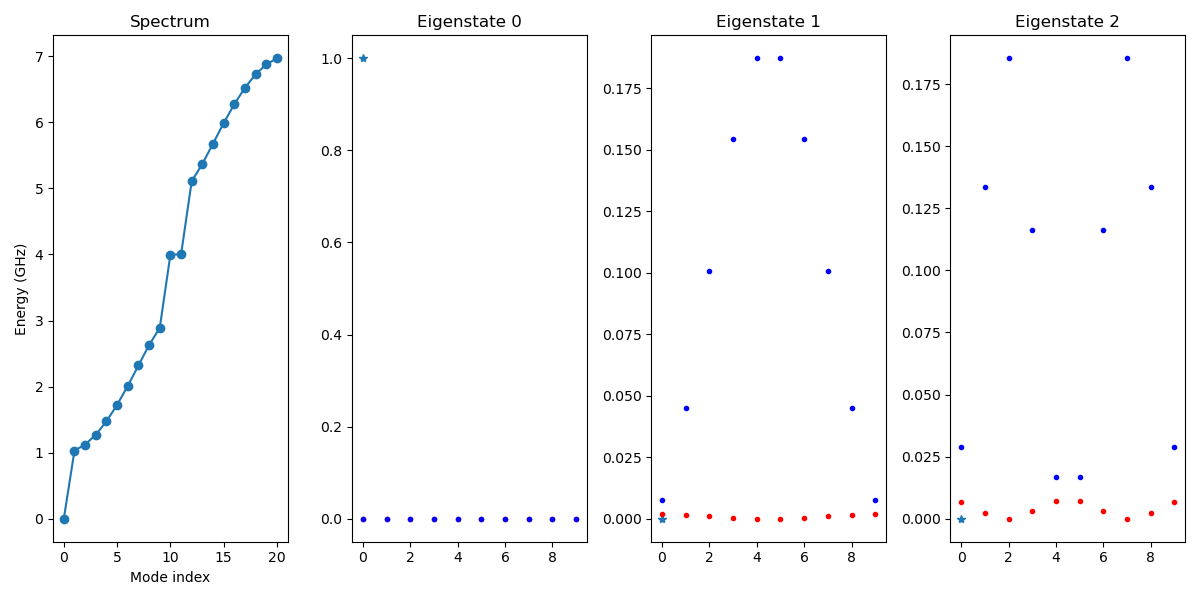

In [62]:
# Plot the eigenvalue spectrum
fig, axs = plt.subplots(ncols=4, figsize=(12,6))

axs[0].plot(np.arange(dim), E, 'o-')
axs[0].set_xlabel('Mode index')
axs[0].set_ylabel('Energy (GHz)')
axs[0].set_title('Spectrum')

for i, ax in enumerate(axs[1:]):
    ax.plot( np.square(np.abs(ψ[0,    i])),'*')
    ax.plot( np.square(np.abs(ψ[1::2, i])),'.r')
    ax.plot( np.square(np.abs(ψ[2::2, i])),'.b')
    ax.set_title(f'Eigenstate {i}')

fig.tight_layout()



In [63]:
Ωd_values = np.linspace(0, 0.5, 100)
E_vs_Ωd = np.zeros([len(Ωd_values), dim])
ψ_vs_Ωd = np.zeros([len(Ωd_values), dim, dim], dtype='complex')

for i, Ωd in enumerate(Ωd_values):

    H_real = H_driven_single_excitation(Δ_c, Δ_q, g_Φ, g_c, g_q, Ωd, δΦd,  N, dense=True, open_bc=True)
    
    E, ψ = np.linalg.eig(H_real)
    E = np.real(E)
    idx_sort = np.argsort(E)
    E_vs_Ωd[i] = E[idx_sort] 
    ψ_vs_Ωd[i] = ψ[:, idx_sort]


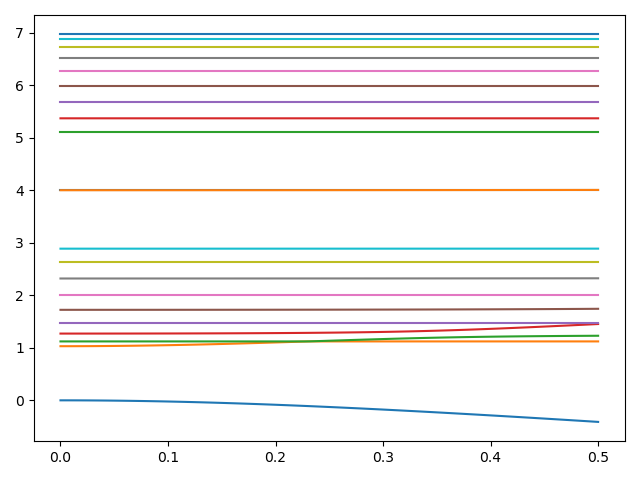

In [64]:
fig, ax = plt.subplots()

ax.plot(Ωd_values, E_vs_Ωd)

fig.tight_layout()

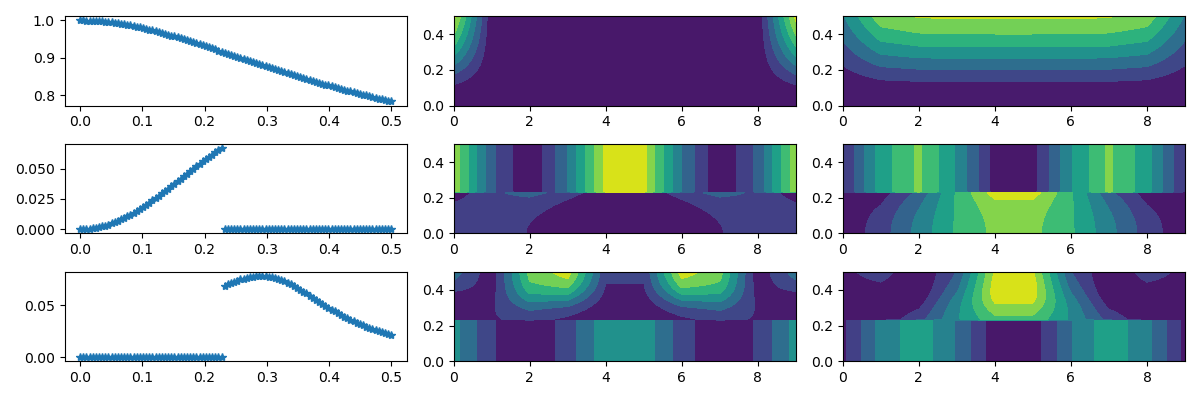

In [65]:
i=0
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[12,4])

for i in range(3):
    axs[i, 0].plot(Ωd_values, np.square(np.abs(ψ_vs_Ωd[:, 0,    i])),'*')
    axs[i, 1].contourf(np.arange(N), Ωd_values, np.square(np.abs(ψ_vs_Ωd[:, 1::2, i])) )
    axs[i, 2].contourf(np.arange(N), Ωd_values, np.square(np.abs(ψ_vs_Ωd[:, 2::2, i])) )

fig.tight_layout()

## Time evolution

In [6]:
δ, g_Φ, g_c, g_q = cases[1]
ω_0 = 0
ω_c = ω_0 - δ / 2   
ω_q = ω_0 + δ / 2   
kappa = 0 
gamma =  0
N=5

In [9]:
# --- build H and initial state ---
H = cm.build_H_single_excitation(ω_c, ω_q, g_Φ, g_c, g_q, N, kappa=kappa, gamma=gamma, open_bc=True, subtract_trace_average=True, dense=False)

# #one excitation on left site
# psi0 = np.zeros(2*N, dtype=np.complex128)
# psi0[0] = 1/np.sqrt(2)
# psi0[1] = 1/np.sqrt(2)

# left edge state
a_left = cm.left_edge_state(δ, g_c, N )
psi0=np.array([ (a_left[i],a_left[i]) for i in range(N)]).reshape(2*N,1).flatten()

g_scale = max(abs(g_q), abs(g_c), abs(g_Φ))
t_max   = 10*N / g_scale
T       = 1000
t_array = np.linspace(0.0, t_max, T)

 
Ps = cm.time_evolve(H, psi0, t_array)
p_a, p_b, P_edge = cm.observables_from_trajectory(Ps, N, n_edge=3)
 

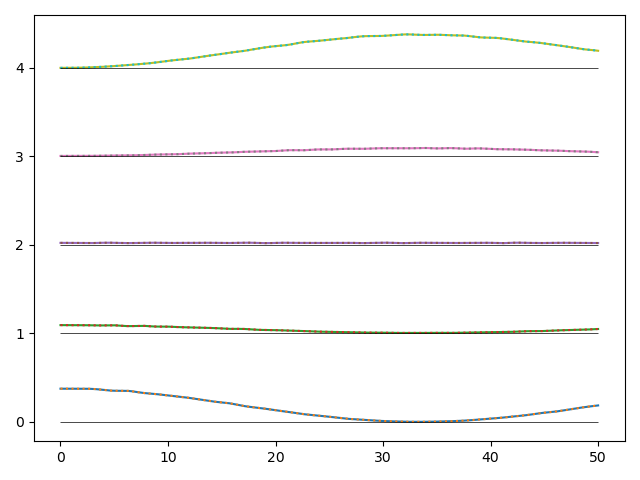

In [10]:
fig, ax = plt.subplots()

for i in range(N):
    ax.plot(t_array, p_a[:,i]+i )
    # ax.plot(t_array, p_a[:,i] )
    ax.plot(t_array, p_b[:,i]+i,':' )
    ax.hlines(i,t_array[0],t_array[-1], linewidth=0.5, color='k' )
    
fig.tight_layout()

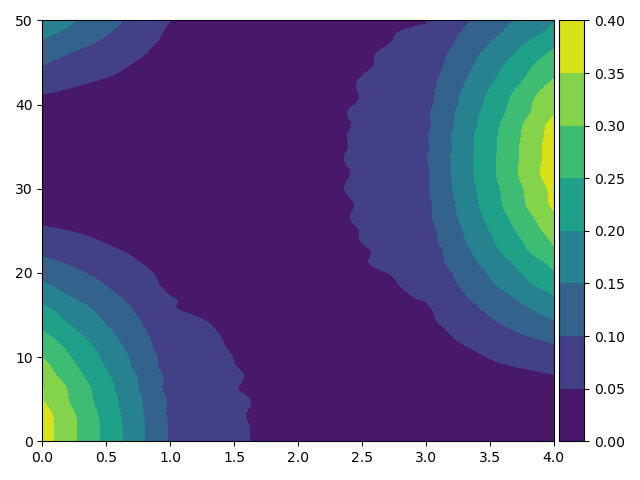

In [11]:
fig, ax = plt.subplots()
cont = ax.contourf(np.arange(N), t_array, p_a )
figs.colorbar(cont)    
fig.tight_layout()

# Time evolution with a driving

## Driving on the first qubit

In [236]:
δ, g_Φ, g_c, g_q = cases[1]
ω_0 = 4
ω_c = ω_0 - δ / 2   
ω_q = ω_0 + δ / 2   
kappa = 0 
gamma =  0

Ω_d = 1
ω_d = 7

N=10

In [237]:
g_scale = max(abs(g_q), abs(g_c), abs(g_Φ))
t_max   = 10*N / g_scale
T       = 1000
t_array = np.linspace(0.0, t_max, T)

In [238]:
Ω_j = np.zeros(N)
ω_j = np.zeros(N)
Φ_j = np.zeros(N)
Ω_j[5] = Ω_d
ω_j[5] = ω_d

In [239]:
H0 = cm.build_H_single_excitation(ω_c, ω_q, g_Φ, g_c, g_q, N, kappa=kappa, gamma=gamma, open_bc=True, dense=False)

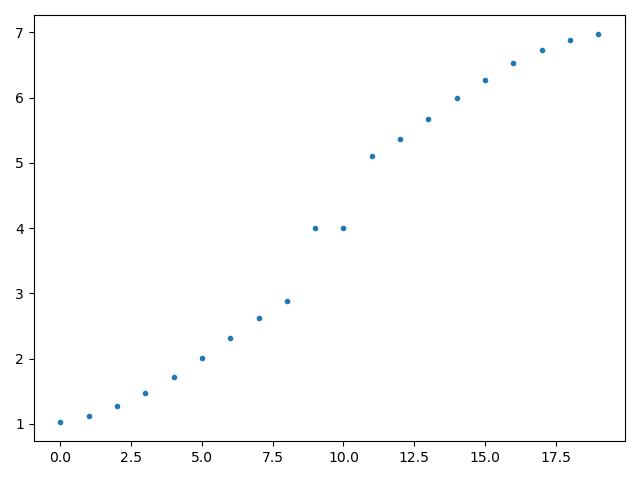

In [240]:
eigvals, eigvecs = np.linalg.eigh(H0.todense())
fig, ax = plt.subplots()

ax.plot(eigvals,'.')

fig.tight_layout()

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'RWA with qubit drive: a (solid), b (dotted)'}, xlabel='time', ylabel='cell index (offset)'>)

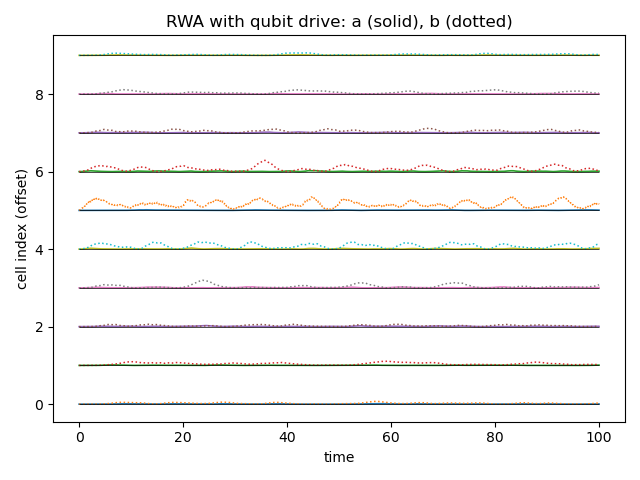

In [241]:

#Vacumm
psi0 = np.zeros(1+2*N, complex); psi0[0]=1

drives = [cm.Drive(site=j, Omega=Ω_j[j], omega=ω_j[j], phi=Φ_j[j])
          for j in range(N)]
states = cm.evolve_with_drives(H0, N, drives, t_array, psi0)
p_vac, p_a, p_b, P_edge = cm.observables_augmented(states, N)
cm.plot_offsets(t_array, p_a, p_b)

## Uniform driving on all qubits, initial state left edge state

In [8]:
δ, g_Φ, g_c, g_q = cases[1]
ω_0 = 2
ω_c = ω_0 - δ / 2   
ω_q = ω_0 + δ / 2   
kappa = 0 
gamma =  0

Ω_d = 0.2
ω_d = ω_0

N=5

In [9]:
g_scale = max(abs(g_q), abs(g_c), abs(g_Φ))
t_max   = 10*N / g_scale
T       = 1000
t_array = np.linspace(0.0, t_max, T)

In [184]:
Ω_j = Ω_d * np.ones(N)
ω_j = ω_d * np.ones(N)
Φ_j = 0   * np.ones(N)

In [10]:
H0 = cm.build_H_single_excitation(ω_c, ω_q, g_Φ, g_c, g_q, N, kappa=kappa, gamma=gamma, open_bc=True, dense=False)

In [185]:

# #Vacumm
# psi0 = np.zeros(1+2*N, complex); psi0[0]=1

# left edge state
a_left = cm.left_edge_state(δ, g_c, N )
psi_edge_single = np.array([ (a_left[i],a_left[i]) for i in range(N)]).reshape(2*N,1).flatten()
psi0 = np.zeros(1+2*N, complex); psi0[1:] = psi_edge_single


drives = [cm.Drive(site=j, Omega=Ω_j[j], omega=ω_j[j], phi=Φ_j[j])
          for j in range(N)]
states = cm.evolve_with_drives(H0, N, drives, t_array, psi0)
p_vac, p_a, p_b, P_edge = cm.observables_augmented(states, N)

C:\Users\gabri\AppData\Local\Temp\ipykernel_30412\843758002.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'RWA with qubit drive: a (solid), b (dotted)'}, xlabel='time', ylabel='cell index (offset)'>)

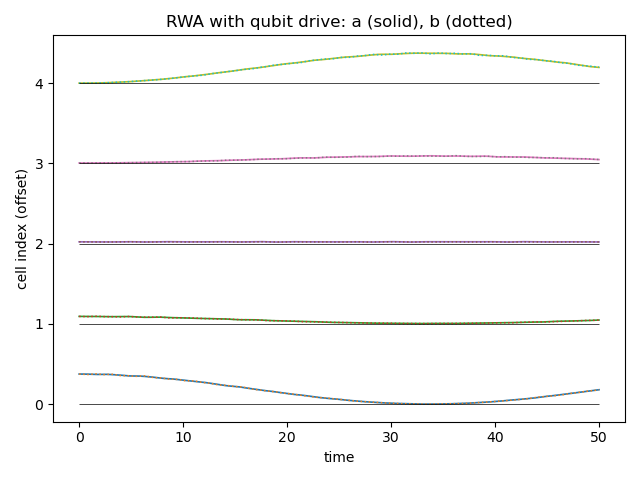

In [186]:

cm.plot_offsets(t_array, p_a, p_b)

In [187]:
plt.close('all')

## Driving spectroscopy

In [280]:
δ, g_Φ, g_c, g_q = cases[1]
ω_0 = 4
ω_c = ω_0 - δ / 2   
ω_q = ω_0 + δ / 2   
kappa = 0 
gamma =  0

N=10

In [281]:
H0 = cm.build_H_single_excitation(ω_c, ω_q, g_Φ, g_c, g_q, N, kappa=kappa, gamma=gamma, open_bc=True, dense=False)
# H0 =augment_with_vacuum(H0)

In [282]:
eigvals, eigvecs = np.linalg.eigh(H0.todense())
sorted_indices = np.argsort(eigvals)
eigvals = eigvals[sorted_indices]
eigvecs=eigvecs[:,sorted_indices]

IndexError: index 20 is out of bounds for axis 1 with size 20

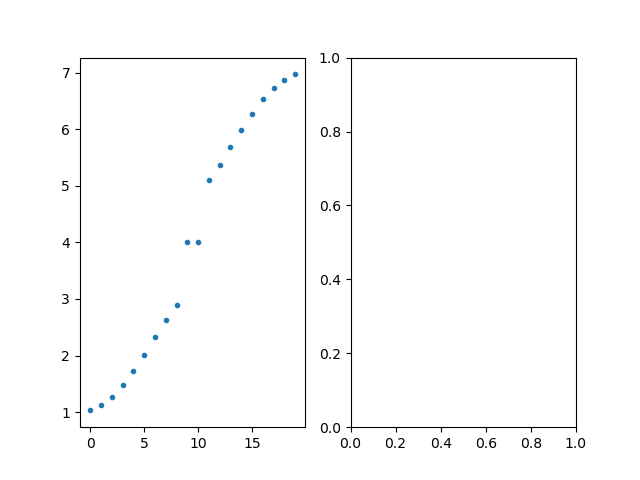

In [283]:
eigvec_index = 20
fig, [ax1, ax2] = plt.subplots(ncols=2)

ax1.plot(eigvals,'.')
ax2.plot(np.square(np.abs(eigvecs[0,eigvec_index])),'*')
ax2.plot(np.square(np.abs(eigvecs[1::2,eigvec_index])),'.')
ax2.plot(np.square(np.abs(eigvecs[2::2,eigvec_index])),'.')

fig.tight_layout()

In [286]:
j_drive = 0
Omega = 0.05      # weak drive
omega_list = np.linspace(0.5, 7.5, 1000 )  # in the same units as H0 entries
omegas, Spec = cm.evolve_drive_time_sweep(H0, N, j_drive, Omega, omega_list,
                                       phi=0.0, gamma=1e-3,
                                       T_trans=100, T_avg=200,
                                       points_per_unit=50)

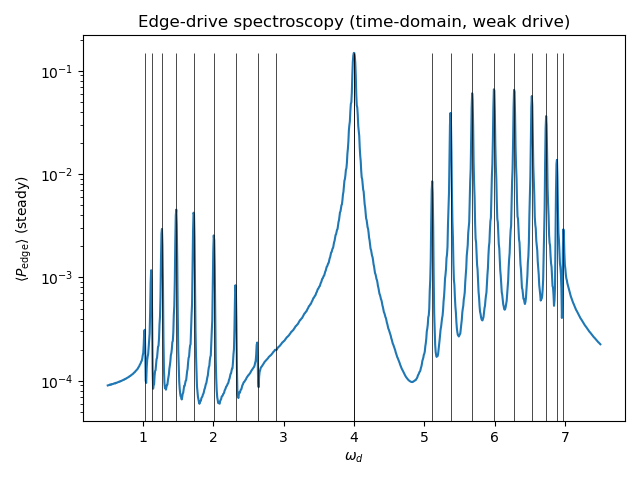

In [290]:
fig, ax = plt.subplots()

ax.plot(omegas, Spec)
ax.set_xlabel(r'$\omega_d$'); plt.ylabel(r'$\langle P_{\rm edge}\rangle$ (steady)')
ax.set_title('Edge-drive spectroscopy (time-domain, weak drive)')
ax.vlines(eigvals,0,np.max(Spec), color='k', linewidth=0.5)
ax.set_yscale('log')
fig.tight_layout()
